# Analysis of Fashion CLIP using Matryoshka SAE

## Imports

In [1]:
%cd /content
!git clone https://github.com/Alloryne/MSAE
%cd /content/MSAE
!pip install -r requirements.txt

/content
fatal: destination path 'MSAE' already exists and is not an empty directory.
/content/MSAE
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m5x4xoj9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m5x4xoj9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
!pip uninstall -y torch torchvision torchaudio transformers torchao
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
!pip install transformers==4.36.2 datasets tqdm pillow

Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Successfully uninstalled torch-2.2.2
Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Found existing installation: transformers 4.45.2
Uninstalling transformers-4.45.2:
  Successfully uninstalled transformers-4.45.2
Found existing installation: torchao 0.10.0
Uninstalling torchao-0.10.0:
  Successfully uninstalled torchao-0.10.0
ERROR: Could not find a version that satisfies the requirement torch==2.1.2 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1, 2.10.0)
ERROR: No matching distribution found for torch==2.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
%cd /content/MSAE

/content/MSAE


In [2]:
from huggingface_hub import hf_hub_download

import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import shutil

import clip
import metrics
from sae import SAE

from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer
from datasets import load_dataset

from torch.utils.data import Dataset, DataLoader
import gc

## Get models

### Get MSAE

In [3]:
orig_load = torch.load
def unsafe_load(*args, **kwargs):
    kwargs["weights_only"] = False
    return orig_load(*args, **kwargs)

torch.load = unsafe_load

In [4]:
path = hf_hub_download(
    repo_id="Alloryne/msae-clip-fashion-4096-topk64",
    filename="MSAE_100.bin"
)

original_path = path  # pytorch_model.bin
expected_name = "4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth"

fixed_path = os.path.join(os.path.dirname(original_path), expected_name)

shutil.copy(original_path, fixed_path)

sae_model = SAE(fixed_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
sae_model.model

Autoencoder(
  (latent_soft_cap): Identity()
  (activation): TopK(
    (act_fn): ReLU()
  )
  (dead_activations): TopK(
    (act_fn): ReLU()
  )
)

In [6]:
sae_model.mean.mean(), sae_model.scaling_factor

(tensor(-0.0076, device='cuda:0'), tensor(2.7760, device='cuda:0'))

### Get Fashion CLIP

In [7]:
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")
model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
tokenizer = CLIPTokenizer.from_pretrained("patrickjohncyh/fashion-clip")

### Get Dataset

In [8]:
dataset_name = "Marqo/KAGL"

dataset = load_dataset(dataset_name)
dataset

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/29 [00:00<?, ?it/s]

DatasetDict({
    data: Dataset({
        features: ['image', 'gender', 'category1', 'category2', 'category3', 'baseColour', 'season', 'year', 'usage', 'text', 'item_ID'],
        num_rows: 44434
    })
})

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

765

## Analysis

### Basic metrics and representations

In [11]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

# Parameters
device = "cuda"  # or "cpu"

model.to(device)
sae_model.to(device)

preprocess = transforms.Compose([
    transforms.Resize((224,224)),  # match CLIP input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

class HFImageDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]["image"]
        img = preprocess(img)  # now tensor
        text = self.dataset[idx]["text"]
        return img, text

def tensor_collate_fn(batch):
    images, texts = zip(*batch)
    images = torch.stack(images)  # now a batch tensor
    return images, list(texts)

train_ds = HFImageDataset(dataset["data"])
dataloader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=False,
    collate_fn=tensor_collate_fn,
    num_workers=2,
    pin_memory=True
)

# Containers
clip_representations = []
sae_representations = []
sae_reconstructed = []
metrics_all = []

model.eval()
sae_model.eval()

for images_batch, _ in tqdm(dataloader):

    # Preprocess images in batch
    images_batch = images_batch.to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        features = model.get_image_features(pixel_values=images_batch)
        features = features / features.norm(dim=-1, keepdim=True)
        post_reconstructed, reconstructed, full_latents = sae_model(features.float())

    # Collect representations
    clip_representations.append(features)
    sae_representations.append(full_latents)
    sae_reconstructed.append(post_reconstructed)

    # Metrics
    fvu = metrics.explained_variance(features, post_reconstructed)
    mae = metrics.normalized_mean_absolute_error(features, post_reconstructed).mean().detach().cpu()
    cs = torch.nn.functional.cosine_similarity(features, post_reconstructed, dim=-1).mean().cpu()
    l0 = metrics.l0_messure(full_latents).mean().detach().cpu()
    highest_magnitude = full_latents.abs().max(dim=-1).values.max().cpu()

    metrics_all.append({
        "fvu": fvu.item() if torch.is_tensor(fvu) else fvu,
        "mae": mae.item(),
        "cs": cs.item(),
        "l0": l0.item(),
        "highest_magnitude": highest_magnitude.item()
    })

# Stack batches
clip_representations = torch.cat(clip_representations)
sae_representations = torch.cat(sae_representations)
sae_reconstructed = torch.cat(sae_reconstructed)

clip_representations.shape, sae_representations.shape

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 348/348 [32:34<00:00,  5.62s/it]


(torch.Size([44434, 512]), torch.Size([44434, 4096]))

### Save metrics and representations

In [13]:
import torch
import numpy as np
import json
import pandas as pd
import os

os.makedirs("results", exist_ok=True)  # folder for outputs

# Save as PyTorch tensors
torch.save(clip_representations, "results/clip_representations.pt")
torch.save(sae_representations, "results/sae_representations.pt")
torch.save(sae_reconstructed, "results/sae_reconstructed.pt")

# Optional: also save as NumPy arrays

with open("results/metrics_all.json", "w") as f:
    json.dump(metrics_all, f, indent=4)

df_metrics = pd.DataFrame(metrics_all)
df_metrics.to_csv("results/metrics_all.csv", index=False)

### Load files back to results

In [9]:
results_dir = "results"

# -------------------------------
# Load PyTorch tensors
clip_representations = torch.load(f"{results_dir}/clip_representations.pt")
sae_representations = torch.load(f"{results_dir}/sae_representations.pt")
sae_reconstructed = torch.load(f"{results_dir}/sae_reconstructed.pt")

print("Shapes (PyTorch):")
print("CLIP:", clip_representations.shape)
print("SAE:", sae_representations.shape)
print("SAE reconstructed:", sae_reconstructed.shape)

# -------------------------------
# Load NumPy arrays (optional)
# clip_representations_np = np.load(f"{results_dir}/clip_representations.npy")
# sae_representations_np = np.load(f"{results_dir}/sae_representations.npy")
# sae_reconstructed_np = np.load(f"{results_dir}/sae_reconstructed.npy")

# print("\nShapes (NumPy):")
# print("CLIP:", clip_representations_np.shape)
# print("SAE:", sae_representations_np.shape)
# print("SAE reconstructed:", sae_reconstructed_np.shape)

# -------------------------------
# Load metrics
with open(f"{results_dir}/metrics_all.json", "r") as f:
    metrics_all = json.load(f)

df_metrics = pd.DataFrame(metrics_all)
print("\nMetrics DataFrame:")
print(df_metrics.head())

# Also load CSV version if needed
df_metrics_csv = pd.read_csv(f"{results_dir}/metrics_all.csv")
print("\nMetrics CSV:")
print(df_metrics_csv.head())

Shapes (PyTorch):
CLIP: torch.Size([44434, 512])
SAE: torch.Size([44434, 4096])
SAE reconstructed: torch.Size([44434, 512])

Metrics DataFrame:
         fvu       mae        cs        l0  highest_magnitude
0  16.538635  4.092509  0.207409  0.356634           2.383896
1  16.243382  4.097859  0.178387  0.362667           2.378036
2  16.367687  4.138670  0.178675  0.357994           2.446396
3  16.464437  4.178334  0.171214  0.356777           2.387802
4  16.524017  4.156446  0.180727  0.354086           2.401474

Metrics CSV:
         fvu       mae        cs        l0  highest_magnitude
0  16.538635  4.092509  0.207409  0.356634           2.383896
1  16.243382  4.097859  0.178387  0.362667           2.378036
2  16.367687  4.138670  0.178675  0.357994           2.446396
3  16.464437  4.178334  0.171214  0.356777           2.387802
4  16.524017  4.156446  0.180727  0.354086           2.401474


### Graphs and metrics

In [14]:
metrics_all = pd.DataFrame(metrics_all)
for col in metrics_all.columns:
    print(f'{col}: {metrics_all[col].mean()} ± {metrics_all[col].std()}')

fvu: 16.429728809444384 ± 0.14443411256823468
mae: 4.148372554230964 ± 0.06375028999329228
cs: 0.1868337236516092 ± 0.026549213677128966
l0: 0.35748447340795364 ± 0.0029277001214656324
highest_magnitude: 2.3269072784774605 ± 0.09935686895996011


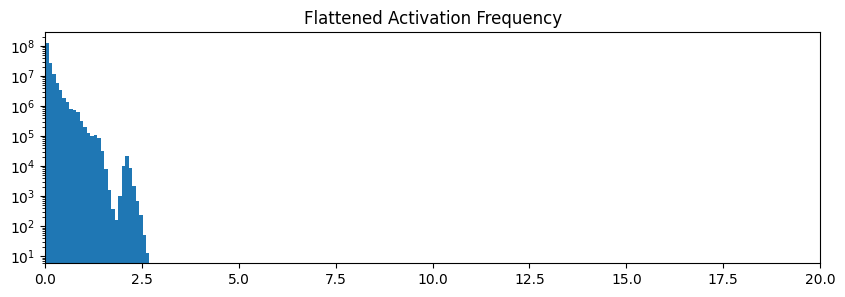

In [15]:
# plot histogram of activations
plt.figure(figsize=(10, 3))
plt.title("Flattened Activation Frequency")
plt.yscale('log')
plt.hist(sae_representations.flatten().cpu().numpy(), bins=30)
plt.xlim(0.0, 20)
plt.show()

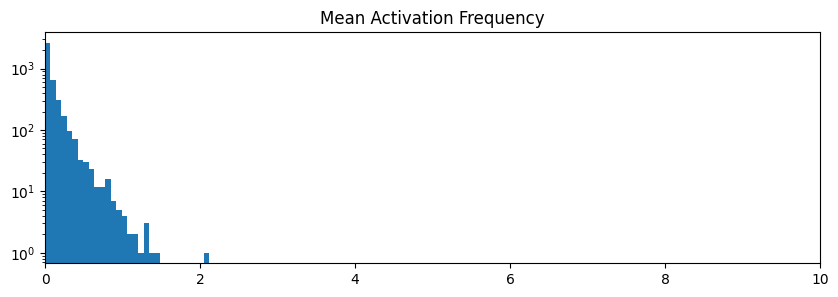

In [39]:
mean_activations = sae_representations.mean(dim=0)
std_activations = sae_representations.std(dim=0)

plt.figure(figsize=(10, 3))
plt.title("Mean Activation Frequency")
plt.yscale('log')
plt.hist(mean_activations.cpu().numpy(), bins=30)
plt.xlim(0.0, 10)
plt.show()

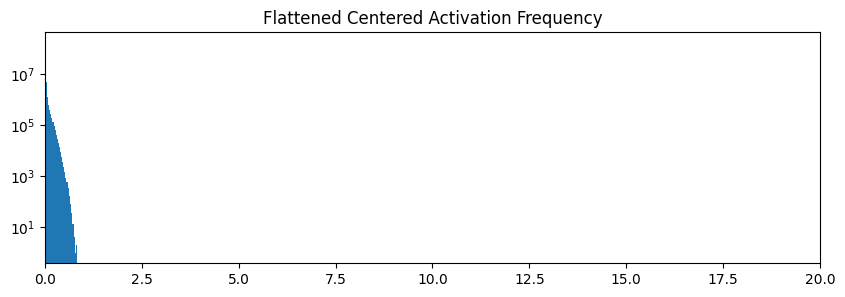

In [17]:
plt.figure(figsize=(10, 3))
plt.title("Flattened Centered Activation Frequency")
plt.yscale('log')
plt.hist(torch.nn.functional.relu(sae_representations-mean_activations).flatten().cpu().numpy(), bins=30)
plt.xlim(0.0, 20)
plt.show()

### Concept detection and validation

Second-best activation:
  image_index = 32765
  neuron_index = 51
  value = 2.6944427490234375


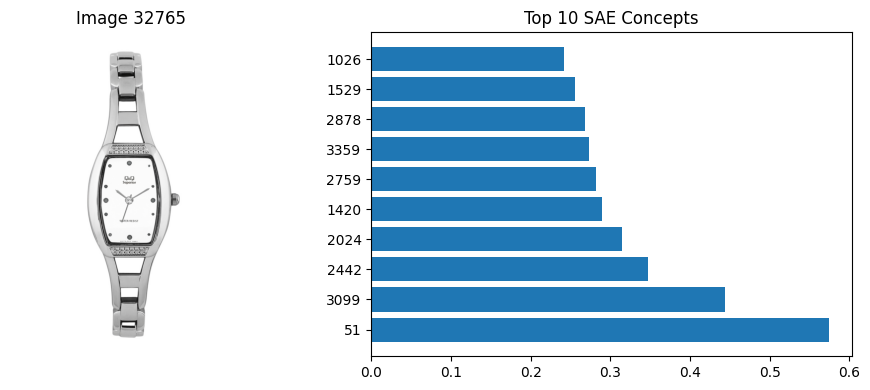

In [18]:
# Find global max activation
# Flatten all activations
flat = sae_representations.view(-1)

top_index = 0
# Top 2 values
top2_vals, top2_idxs = flat.topk(top_index + 1)

# Take second-best
second_val = top2_vals[top_index]
second_flat_idx = top2_idxs[top_index]

# Convert back to (image_index, neuron_index)
image_index = second_flat_idx // sae_representations.shape[1]
argmax_index = second_flat_idx % sae_representations.shape[1]

print(
    f"Second-best activation:\n"
    f"  image_index = {image_index}\n"
    f"  neuron_index = {argmax_index}\n"
    f"  value = {second_val.item()}"
)

# Top 10 concepts for this image
top_10 = (sae_representations - mean_activations)[image_index].topk(10)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Pull image directly from HF dataset
img = dataset["data"][int(image_index)]["image"]

ax[0].imshow(img.convert("RGB"))
ax[0].axis("off")
ax[0].set_title(f"Image {int(image_index)}")

ax[1].barh(range(10), top_10.values.cpu().numpy())
ax[1].set_yticks(range(10))
ax[1].set_yticklabels(top_10.indices.cpu().numpy())
ax[1].set_title(f"Top 10 SAE Concepts")

plt.tight_layout()
plt.show()


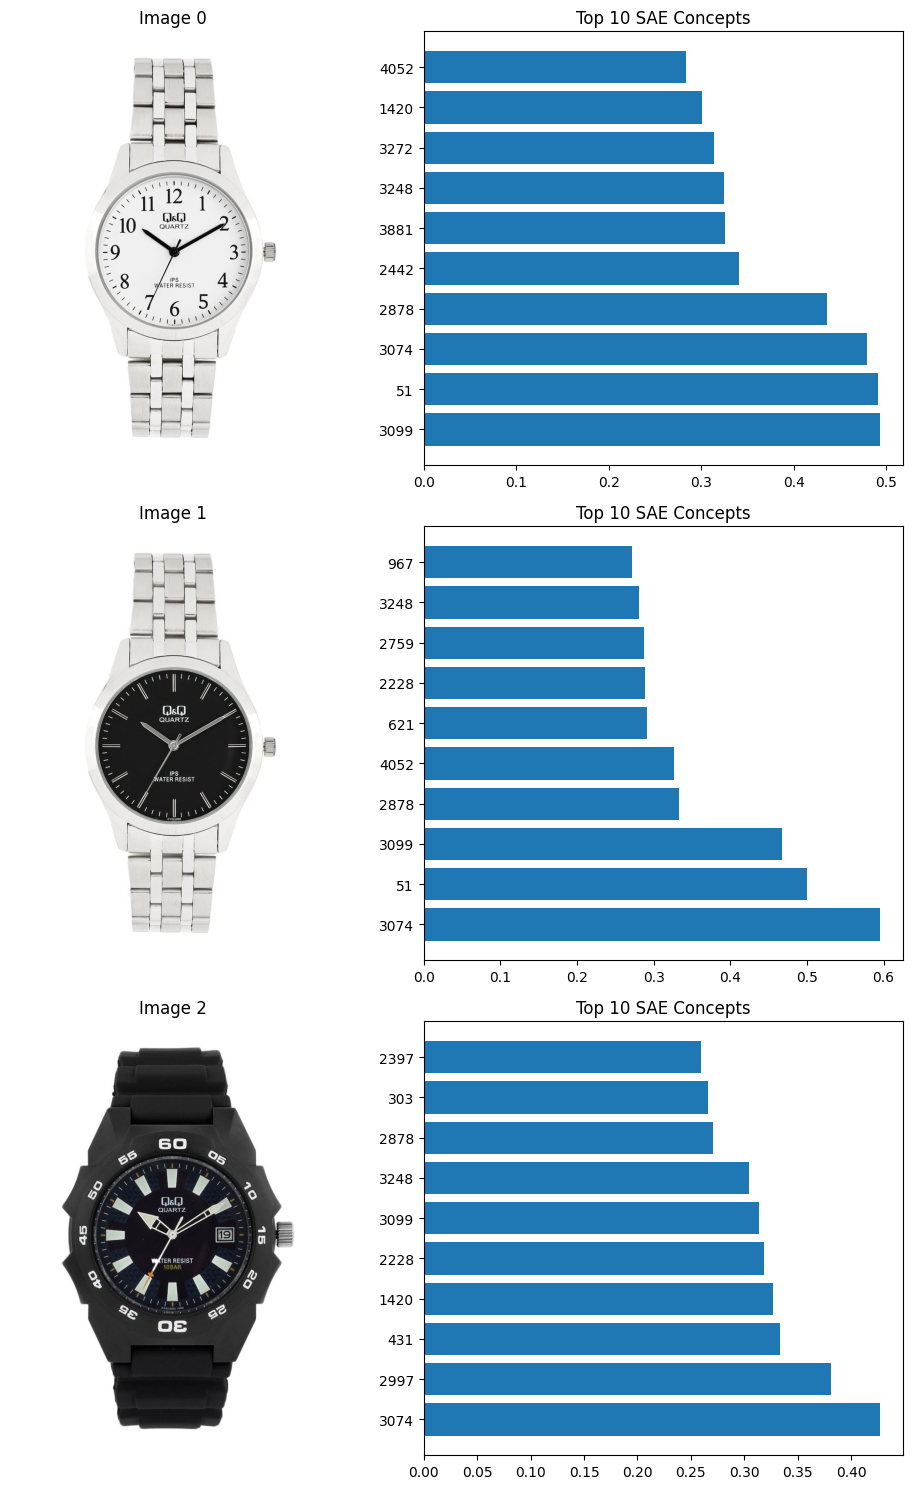

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    # Top 10 SAE concepts for image i
    top_10 = (sae_representations[i + 35678] - mean_activations).topk(10)

    # HF dataset image (already PIL)
    img = dataset["data"][i + 35678]["image"]

    ax[i, 0].imshow(img.convert("RGB"))
    ax[i, 0].axis("off")
    ax[i, 0].set_title(f"Image {i}")

    ax[i, 1].barh(range(10), top_10.values.cpu().numpy())
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_yticklabels(top_10.indices.cpu().numpy())
    ax[i, 1].set_title(f"Top 10 SAE Concepts")

plt.tight_layout()
plt.show()


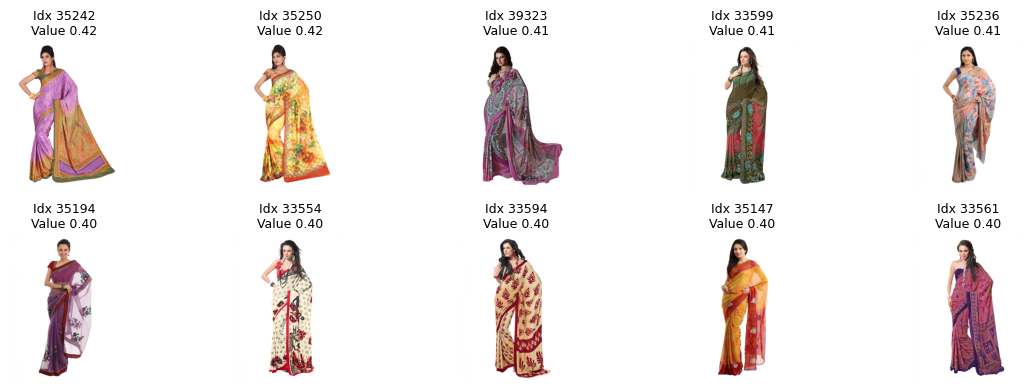

In [31]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))

# Top 10 images activating neuron 0
top_images = sae_representations[:, 327].topk(10)

for i, axi in enumerate(ax.ravel()):
    idx = top_images.indices[i].item()

    # HF dataset image (already PIL)
    img = dataset["data"][idx]["image"]

    axi.imshow(img.convert("RGB"))
    axi.axis("off")
    axi.set_title(
        f"Idx {idx}\nValue {top_images.values[i].item():.2f}",
        fontsize=9
    )

plt.tight_layout()
plt.show()

## Vocabulary

#### Extract text file

In [ ]:
# Get concepts from dataset
columns = [
    "gender",
    "category1",
    "category2",
    "category3",
    "baseColour",
    "season",
    "year",
    "usage",
]

In [ ]:
from tqdm import tqdm
import re

unique_words = set()

# Optional: simple tokenizer (keeps words + numbers)
token_pattern = re.compile(r"[A-Za-z0-9]+")

for row in tqdm(dataset["data"], desc="Processing rows"):
    text = row["text"]
    if not text:
        continue

    # Lowercase for normalization
    text = text.lower()

    # Tokenize
    words = token_pattern.findall(text)

    for w in words:
        if len(w) > 1:
            unique_words.add(w)


Processing rows: 100%|██████████| 44434/44434 [14:23<00:00, 51.49it/s]


In [ ]:
output_path = "vocab/fashion_concepts_text.txt"

with open(output_path, "w") as f:
    for s in sorted(unique_words):
        f.write(s + "\n")

print(f"Saved {len(unique_words)} unique concepts to {output_path}")


Saved 8707 unique concepts to vocab/fashion_concepts_text.txt


#### Get naming file and upload to hugging face

In [19]:
import os
import numpy as np
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch

# Paths
txt_file = "/content/MSAE/vocab/fashion_concepts.txt"  # your text file
output_file = "/content/MSAE/data/KAGL_Fashion-CLIP_vocab_text_251_512.npy"  # single .npy file


# Eval mode
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Read lines
with open(txt_file, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]

all_embeddings = []

# Process each line
for i, text in enumerate(lines):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Get text embeddings
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)  # shape: (1, hidden_dim)

    # Add to list
    all_embeddings.append(text_features.cpu().numpy())

# Stack all embeddings into one array (num_lines x hidden_dim)
all_embeddings = np.vstack(all_embeddings)

# Save to a single .npy file
np.save(output_file, all_embeddings)

print(f"Saved all embeddings to {output_file}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Saved all embeddings to /content/MSAE/data/KAGL_Fashion-CLIP_vocab_text_251_512.npy


In [110]:
!git pull

Already up to date.


In [32]:
folder = "/root/.cache/huggingface/hub/models--Alloryne--msae-clip-fashion-4096-topk64/snapshots/3897d5be5a4dda3a039ee21878544840ecf990b7"

# List all files in the folder
files = os.listdir(folder)
print("Files in folder:", files)

# Filter for .pth files (your SAE model)
model_files = [f for f in files if f.endswith(".pth")]
print("Found model file(s):", model_files)

# Get the full path of the first .pth file
model_path = os.path.join(folder, model_files[0])
print("Full model path:", model_path)

Files in folder: ['4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth', 'MSAE_100.bin']
Found model file(s): ['4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth']
Full model path: /root/.cache/huggingface/hub/models--Alloryne--msae-clip-fashion-4096-topk64/snapshots/3897d5be5a4dda3a039ee21878544840ecf990b7/4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth


In [20]:
# /root/.cache/huggingface/hub/models--Alloryne--msae-clip-fashion-4096-topk64/snapshots/3897d5be5a4dda3a039ee21878544840ecf990b7/4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth
!python sae_naming.py \
  --model /root/.cache/huggingface/hub/models--Alloryne--msae-clip-fashion-4096-topk64/snapshots/3897d5be5a4dda3a039ee21878544840ecf990b7/4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512.pth \
  --vocab /content/MSAE/data/KAGL_Fashion-CLIP_vocab_text_251_512.npy \
  --path-to-save results \
  --batch-size 128 \
  --verbose \
  -w 2

2026-01-23 04:56:48,700 - __main__ - INFO - Model loaded
2026-01-23 04:56:48,701 - __main__ - INFO - Vocabulary dataset loaded with 251
2026-01-23 04:56:48,770 - __main__ - INFO - Input features: 251, Decoder features: 4096
Computing similarities: 100% 2/2 [00:01<00:00,  1.94batch/s]
2026-01-23 04:56:49,810 - __main__ - INFO - Similarity computation complete
2026-01-23 04:56:49,816 - __main__ - INFO - Successfully saved similarity matrix to results/Concept_Interpreter_4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512_KAGL_Fashion-CLIP_vocab_text_251_512
2026-01-23 04:56:49,816 - __main__ - INFO - Vocab ID: 0/251(0.00), Best match SAE index: 0, Score: 0.0
2026-01-23 04:56:49,816 - __main__ - INFO - Vocab ID: 1/251(0.00), Best match SAE index: 3512, Score: 0.13090769946575165
2026-01-23 04:56:49,816 - __main__ - INFO - Vocab ID: 2/251(0.01), Best match SAE index: 3512, Score: 0.13360941410064697
2026-01-23 04:56:49,816 - __main__ - INFO - Vocab ID: 3/251(0.0

In [21]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

In [35]:
import os
import numpy as np

# Path to the local repo
repo_path = "msae-clip-fashion-4096-topk64"

# Make sure folder exists
os.makedirs(repo_path, exist_ok=True)

In [22]:
import shutil
import os

# Source file
src_file = "/content/MSAE/results/Concept_Interpreter_4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512_KAGL_Fashion-CLIP_vocab_text_251_512.npy"

# Destination folder (local clone of the repo)
repo_path = "/content/MSAE/msae-clip-fashion-4096-topk64"

# Ensure repo folder exists
os.makedirs(repo_path, exist_ok=True)

# Destination file path
dst_file = os.path.join(repo_path, os.path.basename(src_file))

# Copy the file
shutil.copy(src_file, dst_file)

print(f"File copied to {dst_file}")

File copied to /content/MSAE/msae-clip-fashion-4096-topk64/Concept_Interpreter_4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512_KAGL_Fashion-CLIP_vocab_text_251_512.npy


In [23]:
from huggingface_hub import upload_file

# Path to your local npy file
file_path = "/content/MSAE/msae-clip-fashion-4096-topk64/Concept_Interpreter_4096_512_TopKReLU_64_RW_False_False_0.0_KAGL_Fashion-CLIP_train_image_39990_512_KAGL_Fashion-CLIP_vocab_text_251_512.npy"

# Repository info
repo_id = "Alloryne/msae-clip-fashion-4096-topk64"  # target repo
path_in_repo = "concept_interpreter_5.npy"  # name for file in repo

# Upload
upload_file(
    path_or_fileobj=file_path,
    path_in_repo=path_in_repo,
    repo_id=repo_id,
    repo_type="model",  # or "dataset" if it's a dataset
    token=True  # True uses your logged-in token
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...IP_vocab_text_251_512.npy:  13%|#3        |  542kB / 4.11MB            

CommitInfo(commit_url='https://huggingface.co/Alloryne/msae-clip-fashion-4096-topk64/commit/cbc71c0da43540fe57d277578ee752d65dda0ddd', commit_message='Upload concept_interpreter_5.npy with huggingface_hub', commit_description='', oid='cbc71c0da43540fe57d277578ee752d65dda0ddd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Alloryne/msae-clip-fashion-4096-topk64', endpoint='https://huggingface.co', repo_type='model', repo_id='Alloryne/msae-clip-fashion-4096-topk64'), pr_revision=None, pr_num=None)

In [25]:
vocab_path = hf_hub_download(
    repo_id="Alloryne/msae-clip-fashion-4096-topk64",
    filename="concept_interpreter_5.npy"
)
concept_match_scores = np.load(vocab_path)
concept_match_scores.shape

concept_interpreter_5.npy:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

(251, 4096)

In [27]:
with open('vocab/fashion_concepts.txt', 'r') as f:
    vocab_names = [line.strip() for line in f.readlines()]
len(vocab_names)

251

In [29]:
top10_names = torch.from_numpy(concept_match_scores)[:,3099].topk(100)
for i in range(100):
    print(f'Top 10 concept for neuron 51: {vocab_names[top10_names.indices[i].item()]} with score {top10_names.values[i].item():.4f}')

Top 10 concept for neuron 51: Lips with score 0.0601
Top 10 concept for neuron 51: Multi with score 0.0527
Top 10 concept for neuron 51: Clutches with score 0.0513
Top 10 concept for neuron 51: Boys with score 0.0503
Top 10 concept for neuron 51: 2014.0 with score 0.0495
Top 10 concept for neuron 51: Skirts with score 0.0483
Top 10 concept for neuron 51: Skin with score 0.0474
Top 10 concept for neuron 51: 2008.0 with score 0.0473
Top 10 concept for neuron 51: 2013.0 with score 0.0460
Top 10 concept for neuron 51: Waistcoat with score 0.0459
Top 10 concept for neuron 51: 2010.0 with score 0.0454
Top 10 concept for neuron 51: 2015.0 with score 0.0454
Top 10 concept for neuron 51: Shrug with score 0.0450
Top 10 concept for neuron 51: Girls with score 0.0449
Top 10 concept for neuron 51: Travel with score 0.0445
Top 10 concept for neuron 51: Lip Gloss with score 0.0432
Top 10 concept for neuron 51: Ipad with score 0.0426
Top 10 concept for neuron 51: Accessories with score 0.0425
Top 10 c

In [30]:
watches_index = 244
top10_neurons = torch.from_numpy(concept_match_scores)[244,:].topk(100)
top10_neurons



torch.return_types.topk(
values=tensor([0.1423, 0.1409, 0.1375, 0.1330, 0.1286, 0.1271, 0.1264, 0.1225, 0.1188,
        0.1172, 0.1158, 0.1136, 0.1124, 0.1097, 0.1088, 0.1085, 0.1077, 0.1072,
        0.1062, 0.1052, 0.1050, 0.1047, 0.1041, 0.1035, 0.1035, 0.1035, 0.1031,
        0.1019, 0.1012, 0.1010, 0.1008, 0.1007, 0.1003, 0.1002, 0.0997, 0.0995,
        0.0991, 0.0989, 0.0989, 0.0988, 0.0980, 0.0978, 0.0974, 0.0970, 0.0970,
        0.0968, 0.0968, 0.0964, 0.0964, 0.0960, 0.0960, 0.0959, 0.0949, 0.0947,
        0.0946, 0.0946, 0.0943, 0.0943, 0.0937, 0.0935, 0.0933, 0.0931, 0.0924,
        0.0921, 0.0920, 0.0919, 0.0919, 0.0915, 0.0914, 0.0907, 0.0906, 0.0904,
        0.0898, 0.0896, 0.0894, 0.0893, 0.0887, 0.0884, 0.0884, 0.0884, 0.0883,
        0.0882, 0.0876, 0.0873, 0.0873, 0.0873, 0.0867, 0.0867, 0.0864, 0.0858,
        0.0855, 0.0855, 0.0851, 0.0851, 0.0848, 0.0844, 0.0842, 0.0841, 0.0840,
        0.0838]),
indices=tensor([ 327,  531, 3858, 3871, 1271, 3229,  226, 1887,  238, 

Max activation:
  image_index = 32765
  neuron_index = 51
  value = 2.6944


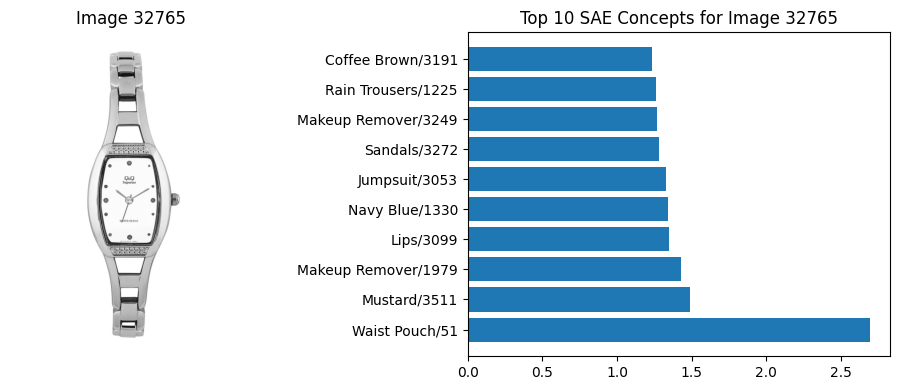

In [32]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# -------------------------------
# Find the neuron with the max activation
max_val = sae_representations.max()
indices = (sae_representations == max_val).nonzero(as_tuple=True)
image_index = indices[0][0].item()
neuron_index = indices[1][0].item()

print(f"Max activation:\n  image_index = {image_index}\n  neuron_index = {neuron_index}\n  value = {max_val.item():.4f}")

# -------------------------------
# Get top 10 SAE concepts for this image
top_10 = sae_representations[image_index].topk(10)

# Map neuron indices to vocab names if concept_match_scores exists
names = []
for idx in top_10.indices.cpu().numpy():
    if 'concept_match_scores' in globals() and idx < concept_match_scores.shape[1]:
        name_idx = concept_match_scores[:, idx].argmax()
        names.append(f"{vocab_names[name_idx]}/{idx}")
    else:
        names.append(f"Neuron {idx}")

# -------------------------------
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Pull image directly from Hugging Face dataset
img = dataset["data"][int(image_index)]["image"]

ax[0].imshow(img.convert("RGB"))
ax[0].axis("off")
ax[0].set_title(f"Image {image_index}")

ax[1].barh(range(10), top_10.values.cpu().numpy())
ax[1].set_yticks(range(10))
ax[1].set_yticklabels(names)
ax[1].set_title(f"Top 10 SAE Concepts for Image {image_index}")

plt.tight_layout()
plt.show()

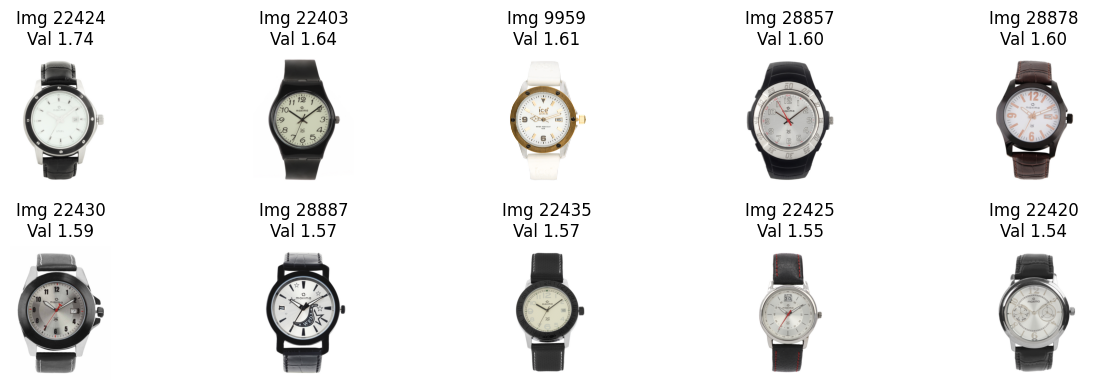

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

# Create a 2x5 plot grid
fig, ax = plt.subplots(2, 5, figsize=(13, 4))

# Pick the neuron index you want to inspect (5465 in this example)
neuron_index = 3099

# Get top 10 images that maximally activate this neuron
top_images = sae_representations[:, neuron_index].topk(10)

for i, axi in enumerate(ax.ravel()):
    img_idx = top_images.indices[i].item()  # index of image in the dataset
    activation_val = top_images.values[i].item()

    # Pull image directly from Hugging Face dataset
    img = dataset["data"][img_idx]["image"]

    axi.imshow(img.convert("RGB"))
    axi.axis("off")
    axi.set_title(f"Img {img_idx}\nVal {activation_val:.2f}")

plt.tight_layout()
plt.show()

### Concept steering

In [52]:

from datasets import DatasetInfo
ds_info = DatasetInfo.from_directory("Marqo/KAGL")

FileNotFoundError: [Errno 2] No such file or directory: '/content/MSAE/Marqo/KAGL/dataset_info.json'

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from tqdm import tqdm
import numpy as np

# -----------------------------
# Load model & processor
processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")
model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# -----------------------------
# Load dataset
dataset_name = "Marqo/KAGL"
dataset = load_dataset(dataset_name)["data"]

# -----------------------------
# Prepare candidate labels (unique category3, cleaned)
unique_category3 = set()
for row in dataset[:1000]:
    val = row.get("category3")
    if val:
        val = str(val).strip().lower()
        unique_category3.add(val)
unique_category3 = sorted(list(unique_category3))
print(f"Found {len(unique_category3)} unique category3 labels")

# -----------------------------
# Tokenize text labels with progress
text_features_list = []
for label in tqdm(unique_category3, desc="Encoding text labels"):
    with torch.no_grad():
        text_input = processor(text=f"a photo of a {label}", return_tensors="pt").to(device)
        feat = model.get_text_features(**text_input)
        feat = feat / feat.norm(dim=-1, keepdim=True)
        text_features_list.append(feat)
text_features = torch.cat(text_features_list, dim=0)

# -----------------------------
# Batch processing images with progress
batch_size = 32
pred_labels = []
true_labels = []

for i in tqdm(range(0, len(dataset), batch_size), desc="Processing images"):
    batch = dataset[i:i+batch_size]
    images = [row["image"] for row in batch]

    # Preprocess images
    with torch.no_grad():
        image_inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**image_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Cosine similarity between images and all text labels
    sims = image_features @ text_features.T  # shape: (batch_size, num_labels)

    # Predicted labels
    batch_preds = sims.argmax(dim=-1).cpu().numpy()
    pred_labels.extend([unique_category3[idx] for idx in batch_preds])

    # True labels (cleaned)
    true_labels.extend([str(row["category3"]).strip().lower() for row in batch])

# -----------------------------
# Simple evaluation
correct = sum(p == t for p, t in zip(pred_labels, true_labels))
accuracy = correct / len(pred_labels)
print(f"Zero-shot Category3 accuracy: {accuracy:.4f}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/29 [00:00<?, ?it/s]

In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# -----------------------------
# Dataset wrapper
class FashionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# -----------------------------
# Prepare features and labels
# Using SAE or CLIP embeddings
X = sae_representations.numpy()  # shape: [num_images, embedding_dim]

# Extract labels from HF dataset
genders = ["Men", "Women", "Unisex"]
le = LabelEncoder()
y = le.fit_transform(genders)  # converts to [0,1,2]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = FashionDataset(X_train, y_train)
test_dataset = FashionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

# -----------------------------
# Simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_classes=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleMLP(X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# -----------------------------
# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(yb.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=le.classes_))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Checking SAE reconstruction quality: 100%|██████████| 44434/44434 [00:07<00:00, 6317.72it/s]


Best-decoded image index: 4001, cosine similarity: 0.4466


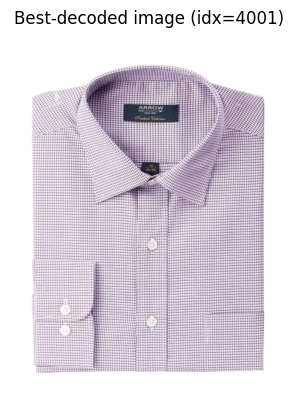

In [80]:
import torch
from tqdm import tqdm

# Assuming sae_representations, sae_reconstructed, clip_representations are already available

cos_sims = []

# Compute cosine similarity for all images between original CLIP features and SAE reconstruction
for i in tqdm(range(len(clip_representations)), desc="Checking SAE reconstruction quality"):
    orig = clip_representations[i].unsqueeze(0)
    recon = sae_reconstructed[i].unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(orig, recon, dim=-1)
    cos_sims.append(sim.item())

cos_sims = torch.tensor(cos_sims)

# Pick the image with highest reconstruction quality
best_idx = torch.argmax(cos_sims).item()
print(f"Best-decoded image index: {best_idx}, cosine similarity: {cos_sims[best_idx]:.4f}")

# Display the image
from PIL import Image
import matplotlib.pyplot as plt

img = dataset["data"][best_idx]["image"]
plt.imshow(img.convert("RGB"))
plt.axis("off")
plt.title(f"Best-decoded image (idx={best_idx})")
plt.show()


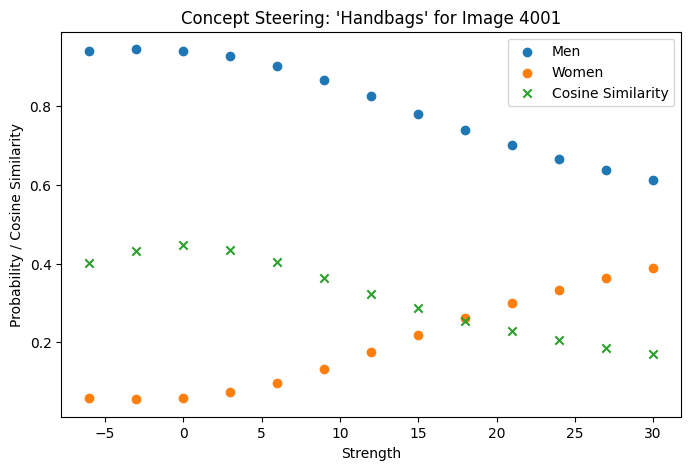

In [87]:
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
img_index = 4001  # image index in your HF dataset
concepts_to_steer = ["Handbags"]  # attributes to steer
strengths = [-6, -3, 0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

# Loop over each concept
for concept_name in concepts_to_steer:

    # Get neuron index for concept
    concept_idx = concept_match_scores[vocab_names.index(concept_name)].argmax()

    # Prepare text prompts for probability evaluation
    prompts = [
        f"Men",      # positive example
        f"Women"     # contrast example
    ]

    with torch.no_grad():
        labels = processor.tokenizer(prompts, return_tensors="pt", padding=True)
        text_features = model.get_text_features(**labels.to(model.device))
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        text_features = model.logit_scale.exp() * text_features

    # Containers for storing results
    prob_pos = []
    prob_neg = []
    cos_sim = []

    # -----------------------------
    # Steering the concept
    for st in strengths:
        with torch.no_grad():
            # Encode via SAE
            _, full_latents = sae_model.encode(image_features)

            # Manipulate concept neuron
            full_latents[:, concept_idx] = st + mean_activations[concept_idx].to(model.device)

            # Decode back to CLIP feature space
            reconstructed = sae_model.model.decode(full_latents)
            post_reconstructed = sae_model.postprocess(reconstructed)

        # Normalize
        post_reconstructed = post_reconstructed / post_reconstructed.norm(dim=1, keepdim=True)

        # Compute probabilities and similarity
        probs = (post_reconstructed @ text_features.t()).softmax(dim=-1).cpu().numpy()
        prob_pos.append(probs[0, 0])
        prob_neg.append(probs[0, 1])
        cos_sim.append(torch.nn.functional.cosine_similarity(post_reconstructed, image_features).item())

    # -----------------------------
    # Plot
    plt.figure(figsize=(8,5))
    plt.scatter(strengths, prob_pos, label=f"Men")
    plt.scatter(strengths, prob_neg, label=f"Women")
    plt.scatter(strengths, cos_sim, label="Cosine Similarity", marker='x')
    plt.title(f"Concept Steering: '{concept_name}' for Image {img_index}")
    plt.xlabel("Strength")
    plt.ylabel("Probability / Cosine Similarity")
    plt.legend()
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
img_index = 0  # index of the image in the HF dataset
concept_name = "red"  # concept you want to steer
strengths = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Get concept neuron index
red_concept = concept_match_scores[vocab_names.index(concept_name)].argmax()

# Prepare text prompts
prompts = [
    f"a photo of a {concept_name} shirt",
    "a photo of a white shirt"  # negative/contrast example
]

with torch.no_grad():
    labels = processor.tokenizer(prompts, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**labels.to(model.device))
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    text_features = model.logit_scale.exp() * text_features

# Initialize containers
prob_concept = []
prob_white = []
cos_sim = []

# Original image features
image_features = clip_representations[img_index].reshape(1, -1).to(model.device)
image_features = image_features / image_features.norm(dim=1, keepdim=True)

# Initial probabilities
probs = (image_features @ text_features.t()).softmax(dim=-1).cpu().numpy()
prob_concept.append(probs[0, 0])
prob_white.append(probs[0, 1])
cos_sim.append(torch.nn.functional.cosine_similarity(image_features, image_features).item())

# -----------------------------
# Steering the concept
for st in strengths[1:]:
    with torch.no_grad():
        # Encode through SAE
        _, full_latents = sae_model.encode(clip_representations[img_index].reshape(1, -1).to(model.device))

        # Manipulate the concept neuron
        full_latents[:, red_concept] = st + mean_activations[red_concept].to(model.device)

        # Decode back to feature space
        reconstructed = sae_model.model.decode(full_latents)
        post_reconstructed = sae_model.postprocess(reconstructed)

    # Normalize
    post_reconstructed = post_reconstructed / post_reconstructed.norm(dim=1, keepdim=True)

    # Compute probabilities and similarity
    probs = (post_reconstructed @ text_features.t()).softmax(dim=-1).cpu().numpy()
    prob_concept.append(probs[0, 0])
    prob_white.append(probs[0, 1])
    cos_sim.append(torch.nn.functional.cosine_similarity(post_reconstructed, image_features).item())

# -----------------------------
# Plot
plt.figure(figsize=(8,5))
plt.scatter(strengths, prob_concept, label=f"{concept_name.capitalize()} Shirt")
plt.scatter(strengths, prob_white, label="White Shirt")
plt.scatter(strengths, cos_sim, label="Cosine Similarity", marker='x')
plt.title(f"Probability vs Strength Steering Concept '{concept_name}'")
plt.xlabel("Strength")
plt.ylabel("Probability / Cosine Similarity")
plt.legend()
plt.show()
